In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../relative_fitness_mechanisms/')
import plot_utils


In [2]:
# Parameters
max_time = 100
times = np.arange(max_time)
num_variants = 120
num_latent = 4

# Fix seed
np.random.seed(12)

# Generate escape
eta = np.random.normal(size=(num_latent, num_variants))

# Generate immune pools
means = np.random.uniform(size=num_latent) * max_time
scales = np.random.uniform(size=num_latent)* 50 + 15
phi = np.exp(-np.square((times[:,None] - means) / scales))
phi = phi / phi.sum(axis=1)[:,None]

# Compute delta
delta_true = phi @ eta 
delta = delta_true + np.random.normal(size=(max_time, num_variants)) * 0.6

Text(0, 0.5, 'Relative fitness')

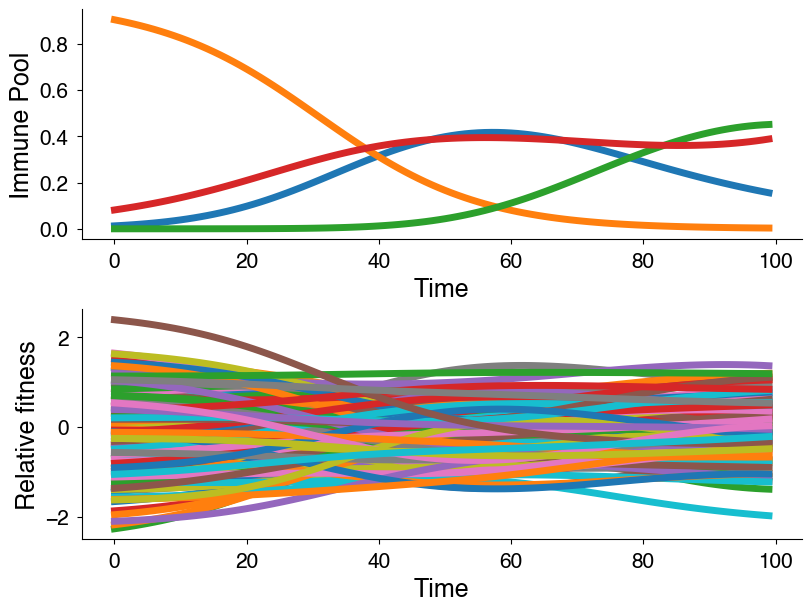

In [3]:
fig = plt.figure(figsize=(8., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)

# Plot immune pools
ax = fig.add_subplot(spec[0, 0])
ax.plot(phi)
ax.set_xlabel("Time")
ax.set_ylabel("Immune Pool")

# Plot relative fitness
ax = fig.add_subplot(spec[1, 0])
ax.plot(phi @ eta)
ax.set_xlabel("Time")
ax.set_ylabel("Relative fitness")

In [4]:
U,S,V = np.linalg.svd(delta_true, full_matrices=False)

(0.0, 10.0)

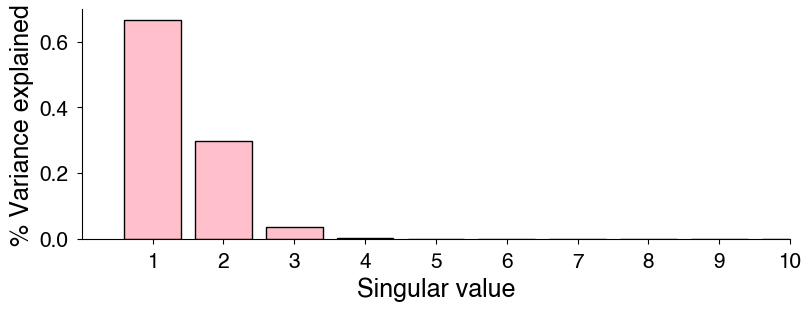

In [21]:
fig = plt.figure(figsize=(8., 3.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

# Plot contribution from singular values
ax = fig.add_subplot(spec[0, 0])
ax.bar(np.arange(S.shape[0])+1, np.square(S) / np.square(S).sum(), ec="k", color="pink")
ax.set_xticks(np.arange(S.shape[0])+1)
ax.set_xlabel("Singular value")
ax.set_ylabel("% Variance explained")
ax.set_xlim((0, 10))

In [6]:
def reconstruct_svd_rank_k(U,S,V, k):
    return (U * S)[:,:k] @ V[:k, :]

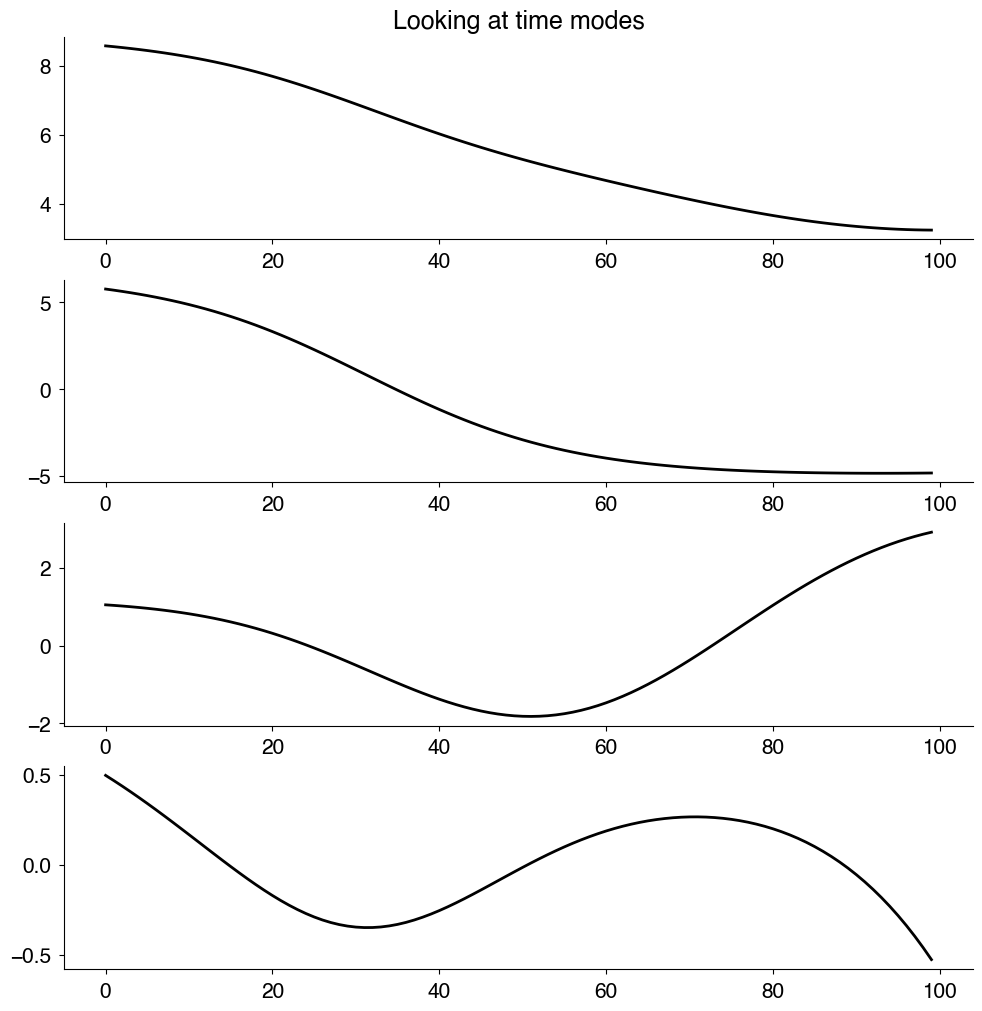

In [7]:
# Plotting learned immune pools and escapes
fig = plt.figure(figsize=(12., 10.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=num_latent, width_ratios=[0.8, 0.2])

reconstruct_k = 2
delta_k = reconstruct_svd_rank_k(U,S,V, reconstruct_k)

for v in range(num_latent):
    ax_ts = fig.add_subplot(spec[v, 0])
    ax_ts.plot(times, (U * S)[:, v], color="k", lw=2, label="True")

    if v == 0:
        ax_ts.set_title(f"Looking at time modes")
        #ax_ts.legend()        
    if v == num_variants - 1:
        ax_ts.set_xlabel("Time")

/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/marlinfiggins/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


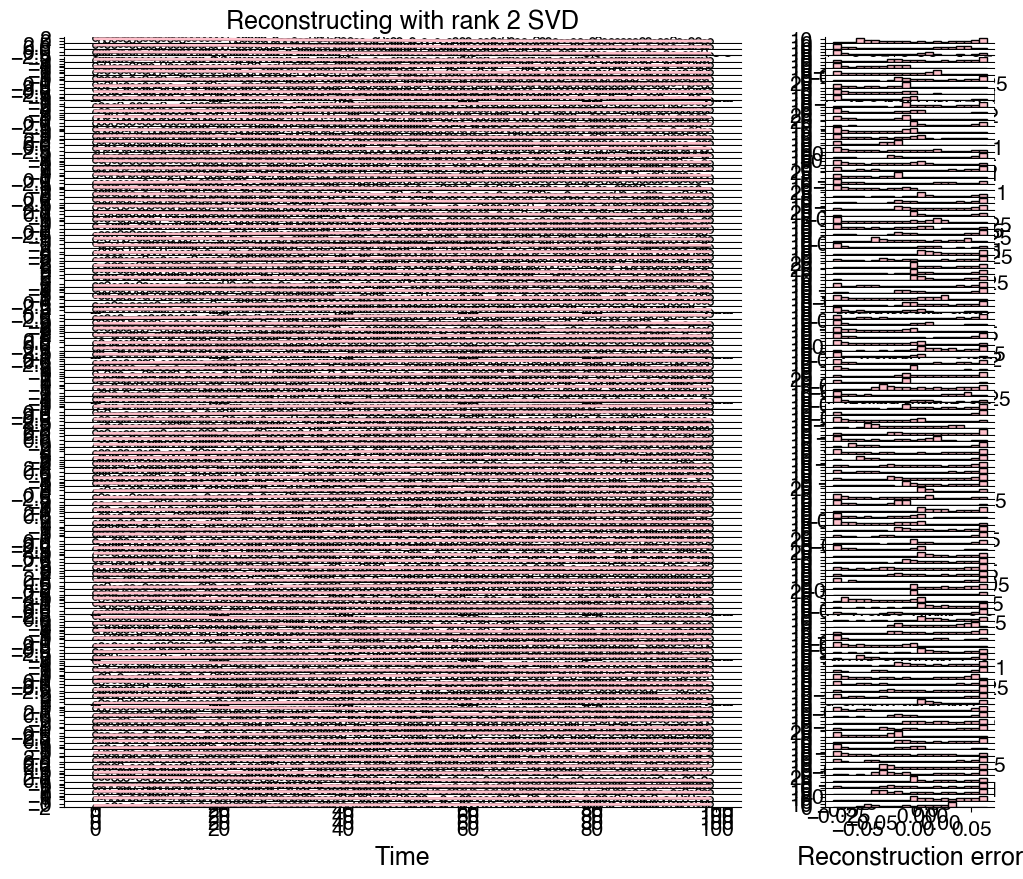

In [8]:

# Plotting reconstruction error for SVD
fig = plt.figure(figsize=(12., 10.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=num_variants, width_ratios=[0.8, 0.2])

reconstruct_k = 2
delta_k = reconstruct_svd_rank_k(U,S,V, reconstruct_k)

for v in range(num_variants):
    ax_ts = fig.add_subplot(spec[v, 0])
    ax_ts.scatter(times, delta[:, v], color="w", ec="k", s=15, label="observed")
    ax_ts.plot(times, delta_true[:, v], color="k", lw=2, label="True")
    ax_ts.plot(times, delta_k[:, v], color="pink", lw=2, label=f"Rank {reconstruct_k} reconstruction")

    if v == 0:
        ax_ts.set_title(f"Reconstructing with rank {reconstruct_k} SVD")
        #ax_ts.legend()
        
    ax_hist = fig.add_subplot(spec[v, 1])
    ax_hist.hist(delta_k[:, v] - delta_true[:, v], color="pink", ec="k", bins=20)
    if v == num_variants - 1:
        ax_ts.set_xlabel("Time")
        ax_hist.set_xlabel("Reconstruction error")
    #ax_hist.set_xlim(-0.2, 0.2)
        


# Takeaway: Things wokr pretty well for low corruption
# We might also want to try a penalized SVD for dealing with possible noise

In [9]:
class RegularizedPCA:
    def __init__(self, dim):
        self.dim = dim
        
    def fit(self, data, pen_P=None, pen_Q=None, lam_P=None, lam_Q=None):
        p, q = data.shape
    
        # Solving for symmetric penalizing matrices
        pen_symP = pen_P.T @ pen_P
        pen_symQ = pen_Q.T @ pen_Q
        
        # Intermediate matrcies for computation
        imatP = np.inv(np.eye(p) + lam_U * pen_symP)
        imatQ = lam_Q * pen_symQ
        K = data.T @ imatP @ data - imatQ
        
        # Find eigenvectors of K
        _, K_eig = np.linalg.eig(K)
        
        # Compute Q and P
        self.Q = K_eig[:, :self.dim]        
        self.P = penalizer_matP @ data @ self.Q
        return self
        
# Following Section 4.2.1 of Majid's thesis

In [10]:
rpca = RegularizedPCA(3)


In [11]:
from scipy.linalg import expm
def skew_sym_basis(i, j, dim):
    K = np.zeros((dim, dim))
    K[i,j] = 1
    K[j, i] = -1
    return K
    
def compute_rotation_basis(dim, dt):
    rot_dts = []
    for i in range(dim):
        for j in range(i+1, dim):
            rot_dts.append(
                expm(dt * skew_sym_basis(i,j,dim))
            )
    return rot_dts
    
class RegularizedSVD:
    def __init__(self, dim, max_iters=100):
        self.dim = dim
        self.max_iters = max_iters
        
    def fit(self, data, pen_U=None, pen_V=None, lam=None, mu=None):
        self.A = data
        
        # Determine shapes
        self.p, self.q = self.A.shape        
        self.pen_U = pen_U if pen_U is not None else np.zeros((1, self.p))
        assert self.pen_U.shape[-1] == self.p, "Mismatched U regularizer shape"
        self.pen_V = pen_V if pen_V is not None else np.zeros((1, self.q))
        assert self.pen_V.shape[-1] == self.q, "Mismatched V regularizer shape"
        
        self.L = self.pen_U.T @ self.pen_U
        self.M = self.pen_V.T @ self.pen_V
       
        self.lam = lam if lam is not None else 0.0
        assert self.lam >= 0., "U penality weight must be non-negative"
        self.mu = mu if mu is not None else 0.0
        assert self.mu >= 0., "V penality weight must be non-negative"

        self.P, self.B, self.Q = self._fit()
        return self
    
    def _fit(self):
        # Initalize Q
        
        # Run gradient descent on psi
        dt = 1e-2
        _, _, Q0 = np.linalg.svd(self.A, full_matrices=False)
        Q0 = Q0[:self.dim,:].T
        Q = self.torus_grad_descent_(Q0,dt)
                
        # With resulting Q, compute P 
        P = []
        for i in range(self.dim):
            _, Pi = self.S_functional(Q[:,i]) 
            P.append(Pi)
        P = np.column_stack(P)
        
        # Compute singular values
        B = np.diag(P.T @ self.A @ Q)
        return P, B, Q
        
    def S_functional(self, Qi):    
        AQi = self.A @ Qi
        SQi = self.lam * self.L - np.outer(AQi, AQi)
        
        # Find smallest eigenvalue and eigenvector
        eig_vals, eig_vecs = np.linalg.eigh(SQi)
        min_ind = np.argmin(eig_vals)
        
        lam1_SQi = eig_vals[min_ind] # Smallest eigenvalue
        v1_SQi = eig_vecs[:, min_ind] # Smallest eigenvector
        return lam1_SQi, v1_SQi
    
    def psi_functional(self, Q):        
        psiQ = 0.0
        for i in range(self.dim):
            Qi = Q[:,i]
            lam1_SQi, _ = self.S_functional(Qi)
            psiQ += lam1_SQi
            psiQ += self.mu * Qi.T @ self.M @ Qi
        return psiQ
        
    def torus_grad_descent_(self, Q0, dt):
        converged = False
        
        rotations = compute_rotation_basis(self.q, dt)
        def _sample_rotation():
            return np.random.choice(int(self.q * (self.q - 1) // 2))
        iters = 0
        Q = Q0
        while not converged:
            # Compute function
            psiQ = self.psi_functional(Q)
            
            # Sample rotation to generate descent
            sampled_rotation = _sample_rotation()
            RQ = rotations[sampled_rotation] @ Q
            psiRQ = self.psi_functional(RQ)
            if psiRQ < psiQ:
                Q = RQ
            iters += 1
            if iters == self.max_iters:
                converged = True
        return Q
    
    def torus_grad_descent(self, Q0, dt):
        converged = False
        
        rotations = compute_rotation_basis(self.q, dt)
        iters = 0
        Q = Q0
        while not converged:
            # Compute function
            psiQ = self.psi_functional(Q)
            
            # Compute gradients for rotation
            dpsi_min = 0.
            rot_best = None
            for rot in rotations:
                RQ = rot @ Q
                psiRQ = self.psi_functional(RQ)
                dpsi = (psiRQ - psiQ) / dt
                if dpsi < dpsi_min:
                    rot_best = rot
                    dpsi_min = dpsi
            if rot_best is None:
                converged = True
            else:
                Q = rot_best @ Q
            iters += 1
            if iters == self.max_iters:
                converged = True
        return Q  

    def transform(self, data):
        pass

In [12]:
def second_derivative_penality(max_time):
    D = np.zeros((max_time, max_time))
    # First row
    D[0,0] = -1
    D[0,1] = 1
    
    # Second row
    D[-1, -2] = 1
    D[-1,-1] = -1
    for i in range(1,max_time-1):
        D[i, i-1] = 1
        D[i,i] = -2
        D[i,i+1] = 1        
    return D

pen_U = second_derivative_penality(100)

In [13]:
my_svd = RegularizedSVD(4, max_iters=500)
my_svd.fit(delta, pen_U=pen_U, lam=5000.5)

In [14]:
Pr, Br, Qr = my_svd.P, my_svd.B, my_svd.Q

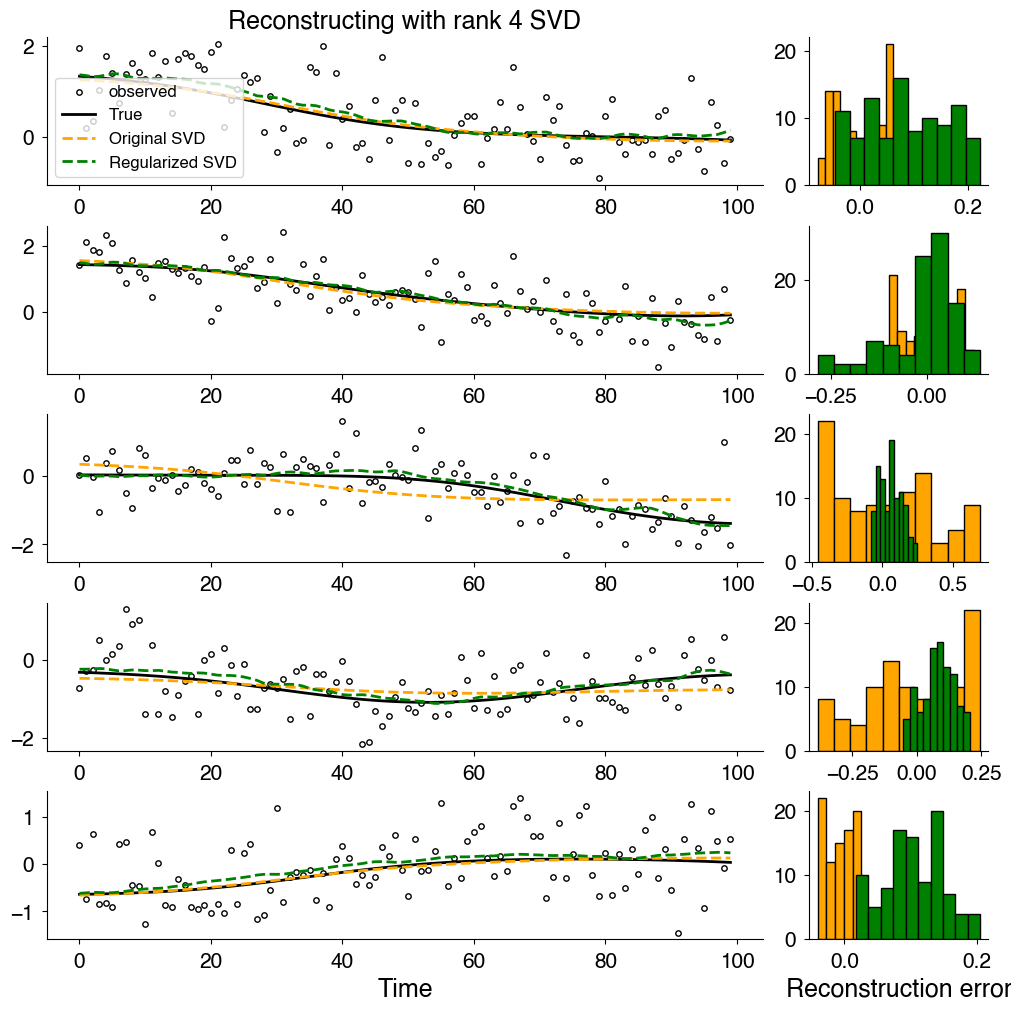

In [25]:
PLOT_VARIANTS = 5
fig = plt.figure(figsize=(10., 10.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=PLOT_VARIANTS, width_ratios=[0.8, 0.2])

reconstruct_k = 4
delta_kr = reconstruct_svd_rank_k(Pr, Br, Qr.T, reconstruct_k)

for v in range(PLOT_VARIANTS):
    ax_ts = fig.add_subplot(spec[v, 0])
    ax_ts.scatter(times, delta[:, v], color="w", ec="k", s=15, label="observed")
    ax_ts.plot(times, delta_true[:, v], color="k", lw=2, label="True")
    ax_ts.plot(times, delta_k[:, v], color="orange", lw=2, linestyle="--", label=f"Original SVD")
    ax_ts.plot(times, delta_kr[:, v], color="g", lw=2, linestyle="--", label=f"Regularized SVD")


    if v == 0:
        ax_ts.set_title(f"Reconstructing with rank {reconstruct_k} SVD")
        ax_ts.legend()
        
    ax_hist = fig.add_subplot(spec[v, 1])
    ax_hist.hist(delta_k[:, v] - delta_true[:, v], color="orange", ec="k")
    ax_hist.hist(delta_kr[:, v] - delta_true[:, v], color="g", ec="k")

    if v == PLOT_VARIANTS - 1:
        ax_ts.set_xlabel("Time")
        ax_hist.set_xlabel("Reconstruction error")

In [16]:
# What is the analogue?
# We want delta = PhiEta, where Phi (T, S), Eta (S, V) where Phi.sum(axis=1) == 1, Phi > 0

In [17]:
# We want to transform Phi -> 